# Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from copy import deepcopy

from torchmetrics import JaccardIndex  # This is the same as MeanIoU

In [2]:
# Method 1: Basic cleanup
import torch
import gc

def cleanup():
    # Clear GPU cache
    torch.cuda.empty_cache()
    # Garbage collect
    gc.collect()

cleanup()

# Device

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Hyperparameters

In [4]:
batch_size = 14
num_classes = 30  # Change as per your dataset
num_epochs = 100
learning_rate = 0.0002

# Color ID for different objects

In [5]:
id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking /no
    6: (230,150,140), #rail track /no
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge /no
    12: (150,120, 90), #tunnel /no
    13: (153,153,153), #pole   /no
    14: (153,153,153), #polegroup /no
    15: (250,170, 30), #traffic light /no
    16: (220,220,  0), #traffic sign /no
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider /no
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train /no 
    28: (  0,  0,230), #motorcycle /no
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

In [22]:
def preprocess_masks(image_dir, save_dir):
    """
    Preprocess all masks and save them as numpy arrays
    """
    # Create save directory if it doesn't exist
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    print("Preprocessing masks...")
    for img_file in tqdm(image_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        
        # Get mask portion (right half of image)
        mask_img = img.crop((256, 0, 512, 256)).resize((256, 256))
        mask_np = np.array(mask_img)
        
        # Create mask using vectorized operations
        h, w = mask_np.shape[:2]
        mask = np.zeros((h, w), dtype=np.int64)
        
        # Vectorized nearest neighbor search
        mask_flat = mask_np.reshape(-1, 3)
        colors = np.array(list(id_map.values()))
        distances = np.linalg.norm(mask_flat[:, np.newaxis] - colors, axis=2)
        nearest_class = np.argmin(distances, axis=1)
        mask = nearest_class.reshape(h, w)
        
        # Save preprocessed mask
        save_path = save_dir / f"{os.path.splitext(img_file)[0]}_mask.npy"
        np.save(save_path, mask)

In [23]:
# Directories
image_dir = "cityscapes_data/cityscapes_data/train"
mask_dir = "cityscapes_data/cityscapes_data/mask"

# Preprocess masks (run once)
#preprocess_masks(image_dir, mask_dir)

# Dataloader

In [24]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_file = self.image_files[idx]
        img_path = self.image_dir / img_file
        img = Image.open(img_path)
        
        # Get input image (left half)
        img = img.crop((0, 0, 256, 256)).resize((256, 256))
        
        # Transform image
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.FloatTensor(np.array(img).transpose(2, 0, 1)) / 255.0
        
        # Load preprocessed mask
        mask_path = self.mask_dir / f"{os.path.splitext(img_file)[0]}_mask.npy"
        mask = np.load(mask_path)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
        
        return img, mask

# Create transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
               std=[0.229, 0.224, 0.225])
])


In [25]:
def create_data_loaders(image_dir, mask_dir, batch_size, val_split=0.2):
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    # Split into train and validation
    train_files, val_files = train_test_split(image_files, test_size=val_split, random_state=42)
    
    # Create custom datasets
    class CityscapeDatasetWithFiles(CityscapeDataset):
        def __init__(self, image_dir, mask_dir, file_list, transform=None):
            super().__init__(image_dir, mask_dir, transform)
            self.image_files = file_list
    
    # Create train and validation datasets
    train_dataset = CityscapeDatasetWithFiles(image_dir, mask_dir, train_files)
    val_dataset = CityscapeDatasetWithFiles(image_dir, mask_dir, val_files)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [26]:
# Create training and validation loaders
train_loader, val_loader = create_data_loaders(image_dir, mask_dir, batch_size)
len(train_loader)
len(val_loader)

43

# UNet architecture

In [6]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        def up_block(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )
        
        # Encoder path
        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.enc5 = conv_block(512, 1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Decoder path
        self.up4 = up_block(1024, 512)
        self.dec4 = conv_block(1024, 512)  # 512 + 512 = 1024 input channels
        
        self.up3 = up_block(512, 256)
        self.dec3 = conv_block(512, 256)   # 256 + 256 = 512 input channels
        
        self.up2 = up_block(256, 128)
        self.dec2 = conv_block(256, 128)   # 128 + 128 = 256 input channels
        
        self.up1 = up_block(128, 64)
        self.dec1 = conv_block(128, 64)    # 64 + 64 = 128 input channels
        
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))
        
        # Decoder
        d4 = self.up4(e5)
        d4 = torch.cat([e4, d4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([e3, d3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([e2, d2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([e1, d1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final_conv(d1)

# Training main code

In [28]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True, min_epochs=10):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.min_epochs = min_epochs
        self.epoch_counter = 0
    
    def __call__(self, val_loss, model):
        self.epoch_counter += 1
        
        # Don't start early stopping until minimum epochs are reached
        if self.epoch_counter < self.min_epochs:
            if self.best_loss is None or val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_model = deepcopy(model.state_dict())
            return
        
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
            self.counter = 0

  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 1  8 14]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


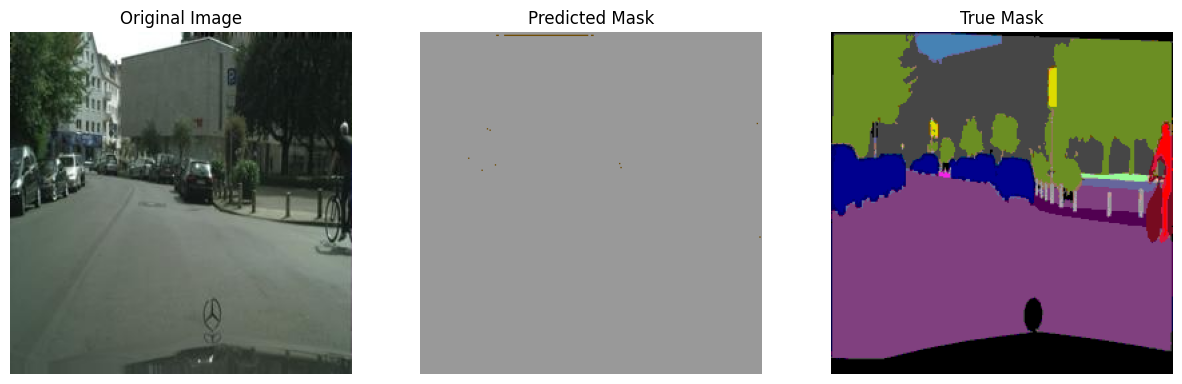

Validation: 100%|██████████| 43/43 [00:30<00:00,  1.41it/s]



Epoch [1/100]
Training Loss: 2.3512, Training mIoU: 0.0228
Validation Loss: 1.8605, Validation mIoU: 0.0570


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  3  7 17 19 22 23]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


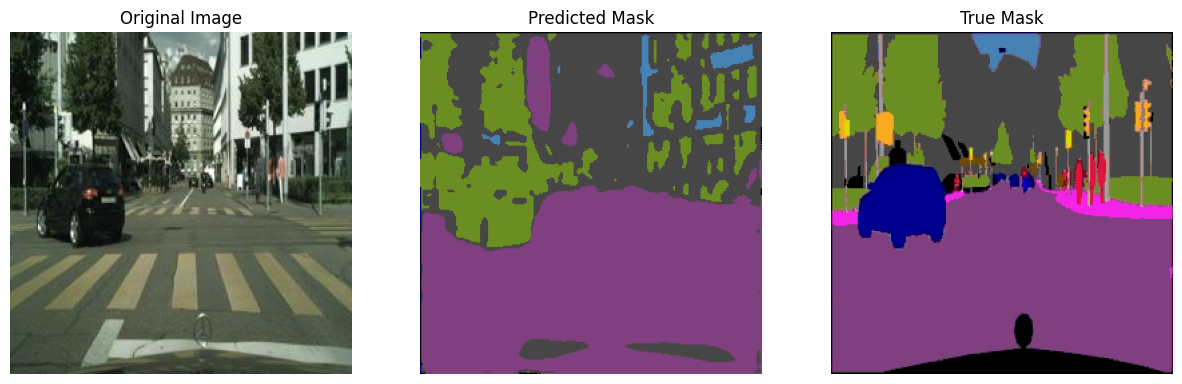

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



Epoch [2/100]
Training Loss: 1.4329, Training mIoU: 0.0895
Validation Loss: 1.2332, Validation mIoU: 0.1151


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7 17 19 22 23]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


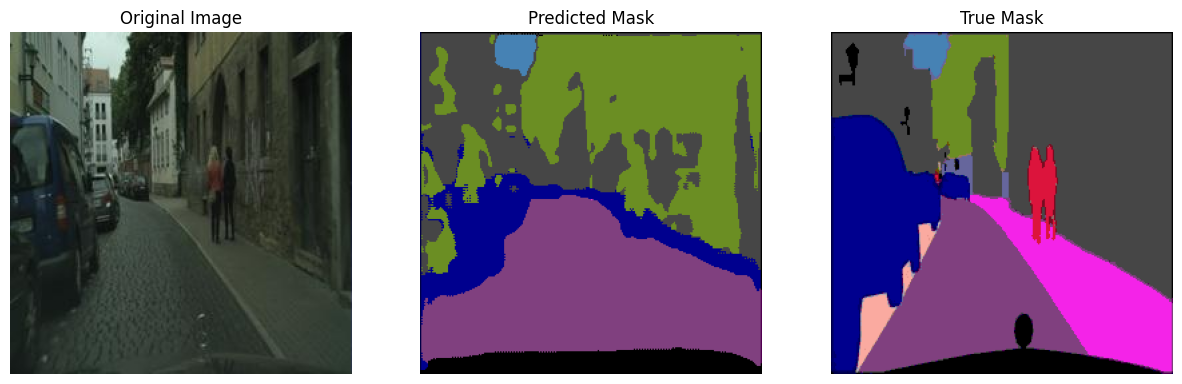

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.96it/s]



Epoch [3/100]
Training Loss: 1.1866, Training mIoU: 0.1212
Validation Loss: 1.1553, Validation mIoU: 0.1256


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7 17 19 22 23]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


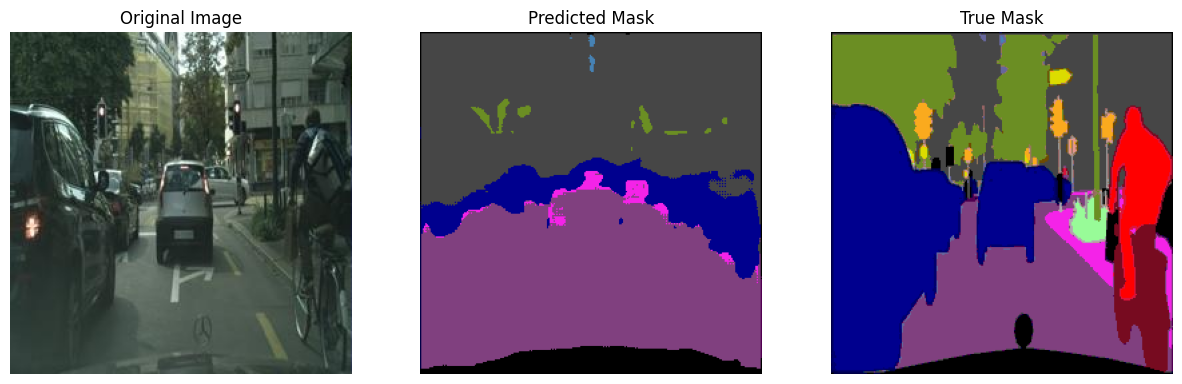

Validation: 100%|██████████| 43/43 [00:07<00:00,  6.01it/s]



Epoch [4/100]
Training Loss: 1.1101, Training mIoU: 0.1325
Validation Loss: 1.0696, Validation mIoU: 0.1389


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8 17 19 22 23]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


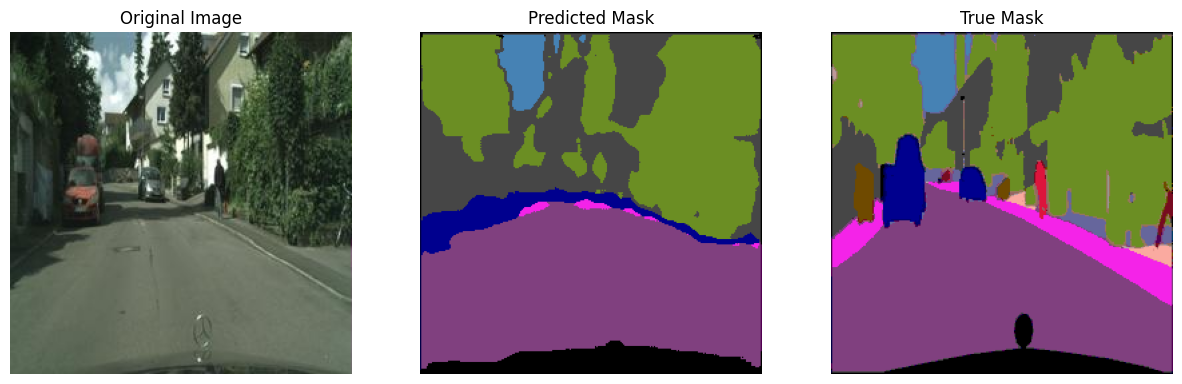

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.95it/s]



Epoch [5/100]
Training Loss: 1.0392, Training mIoU: 0.1450
Validation Loss: 1.0096, Validation mIoU: 0.1549


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8 17 18 19 22 23 26]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


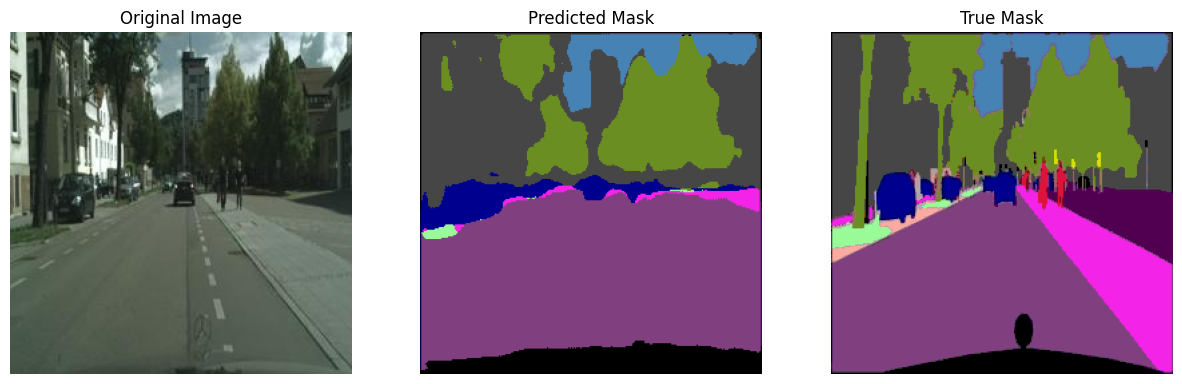

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.97it/s]



Epoch [6/100]
Training Loss: 0.9762, Training mIoU: 0.1609
Validation Loss: 0.9437, Validation mIoU: 0.1694


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8 17 18 19 22 23 26]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


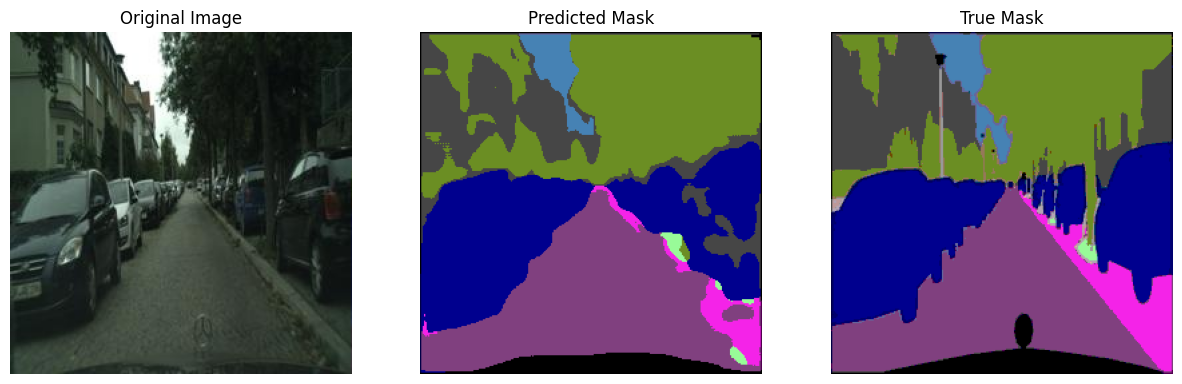

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.96it/s]



Epoch [7/100]
Training Loss: 0.9116, Training mIoU: 0.1741
Validation Loss: 0.8957, Validation mIoU: 0.1756


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8 17 18 19 22 23 26]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


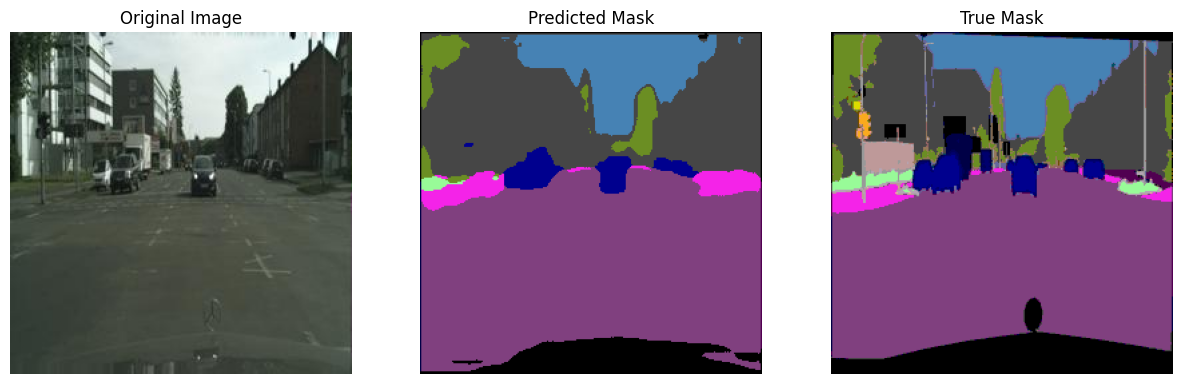

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.99it/s]



Epoch [8/100]
Training Loss: 0.8700, Training mIoU: 0.1812
Validation Loss: 0.8693, Validation mIoU: 0.1831


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


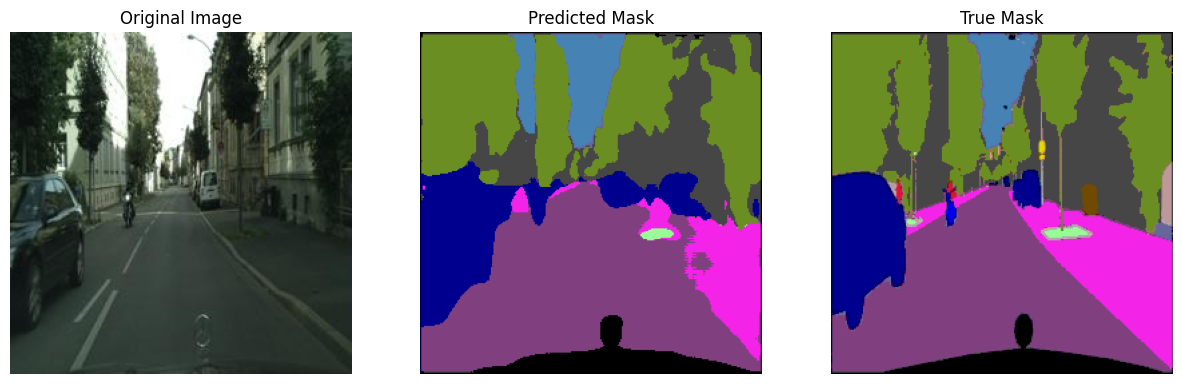

Validation: 100%|██████████| 43/43 [00:07<00:00,  6.05it/s]



Epoch [9/100]
Training Loss: 0.8342, Training mIoU: 0.1878
Validation Loss: 0.8583, Validation mIoU: 0.1848


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


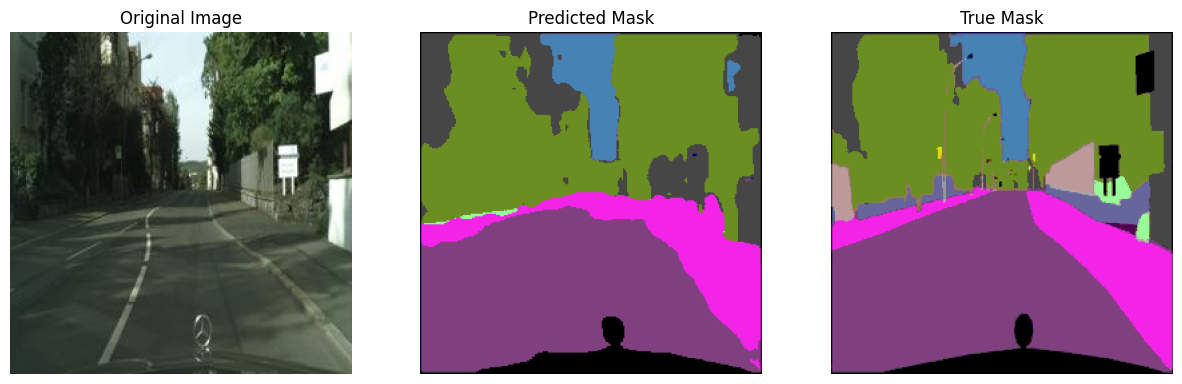

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.90it/s]



Epoch [10/100]
Training Loss: 0.8023, Training mIoU: 0.1940
Validation Loss: 0.8316, Validation mIoU: 0.1922


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


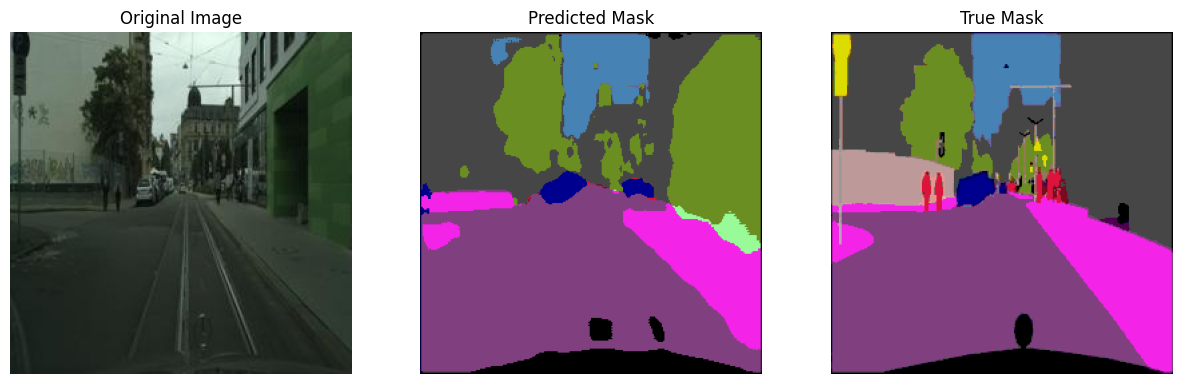

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.89it/s]



Epoch [11/100]
Training Loss: 0.7801, Training mIoU: 0.2008
Validation Loss: 0.7770, Validation mIoU: 0.2039


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


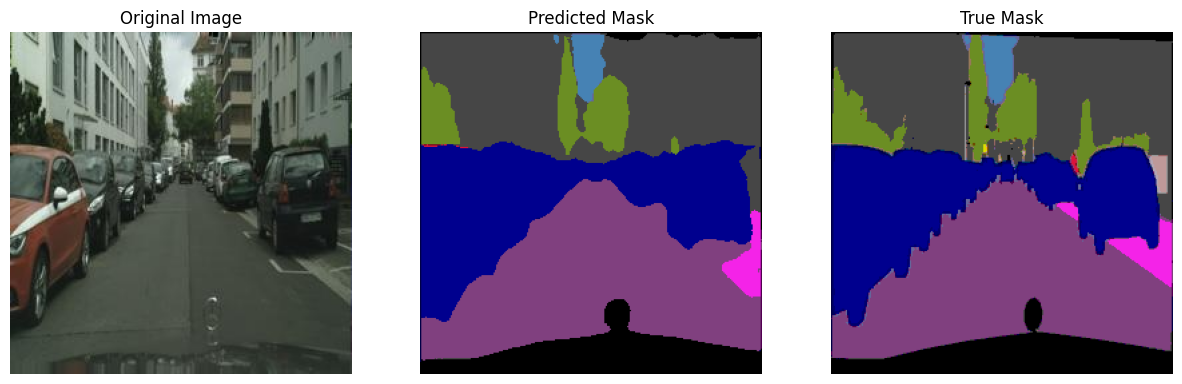

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.92it/s]



Epoch [12/100]
Training Loss: 0.7480, Training mIoU: 0.2077
Validation Loss: 0.7685, Validation mIoU: 0.2061


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


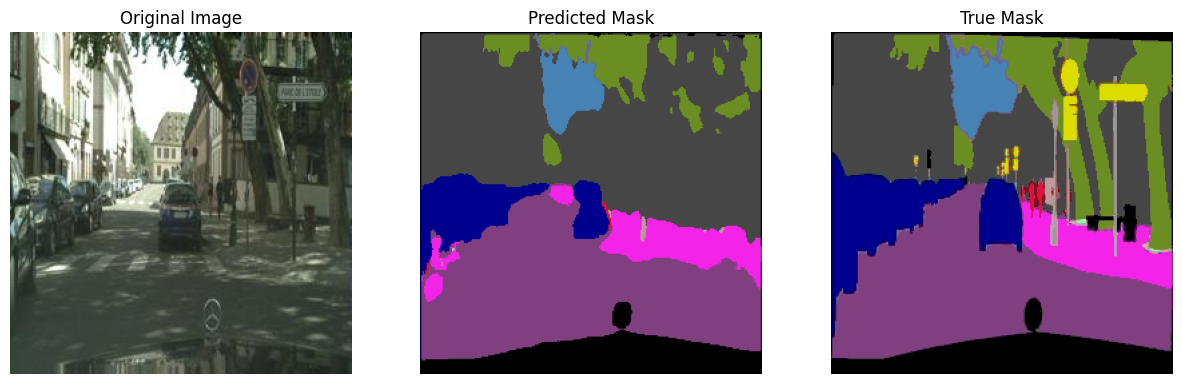

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.85it/s]



Epoch [13/100]
Training Loss: 0.7298, Training mIoU: 0.2119
Validation Loss: 0.7426, Validation mIoU: 0.2122


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 12 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


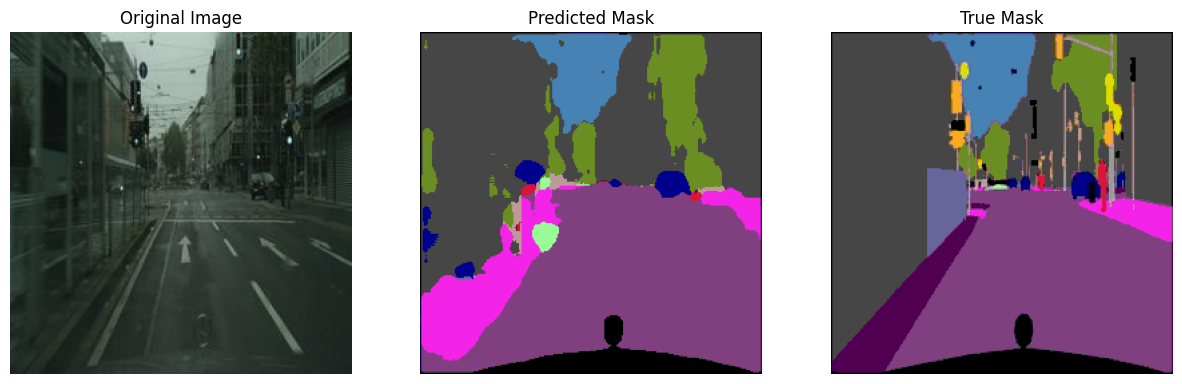

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.67it/s]



Epoch [14/100]
Training Loss: 0.7114, Training mIoU: 0.2160
Validation Loss: 0.7588, Validation mIoU: 0.2103
EarlyStopping counter: 1 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 12 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


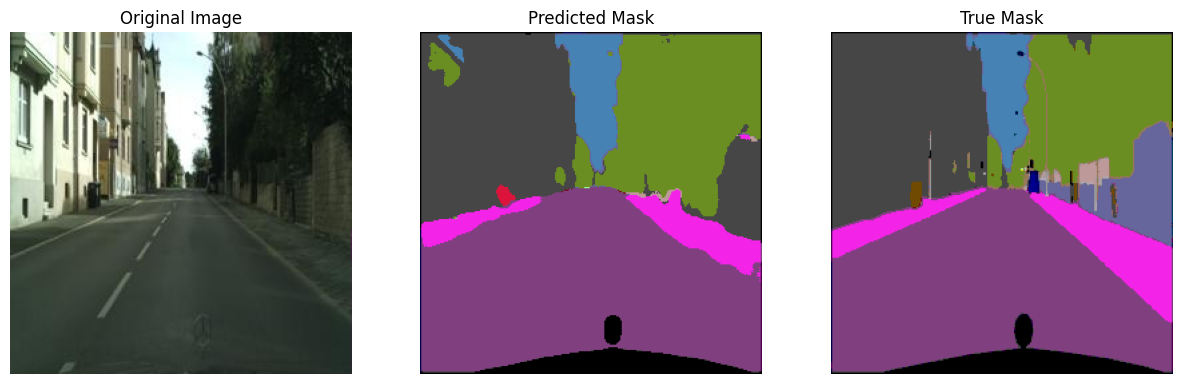

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.67it/s]



Epoch [15/100]
Training Loss: 0.6915, Training mIoU: 0.2207
Validation Loss: 0.7148, Validation mIoU: 0.2194


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 12 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


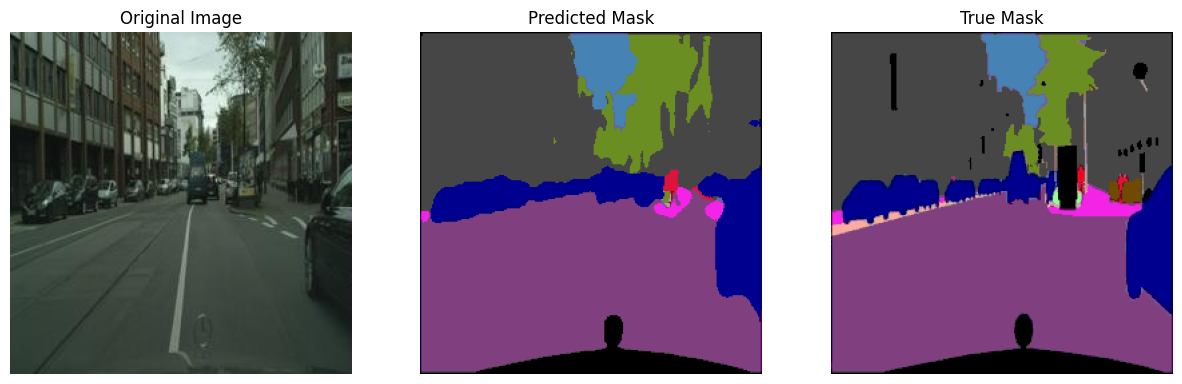

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s]



Epoch [16/100]
Training Loss: 0.6740, Training mIoU: 0.2251
Validation Loss: 0.7363, Validation mIoU: 0.2169
EarlyStopping counter: 1 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 12 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


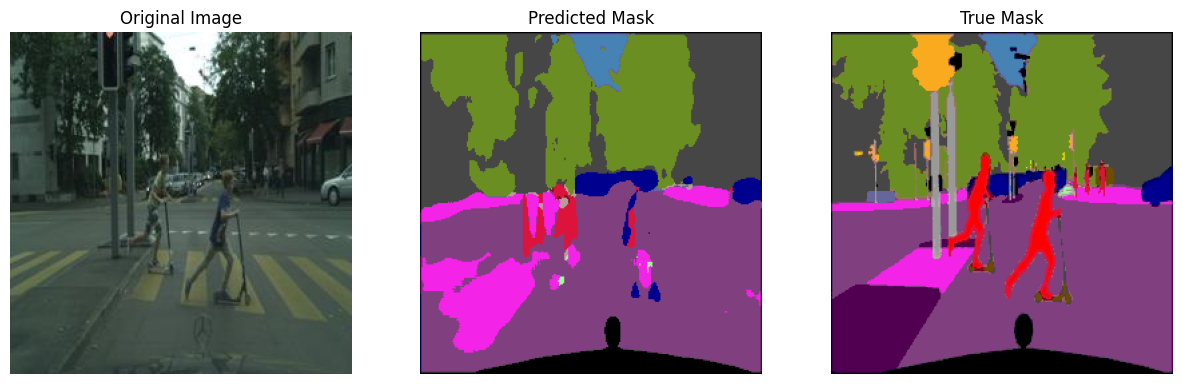

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.86it/s]



Epoch [17/100]
Training Loss: 0.6564, Training mIoU: 0.2293
Validation Loss: 0.6930, Validation mIoU: 0.2247


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 17 18 19 20 22 23 24 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


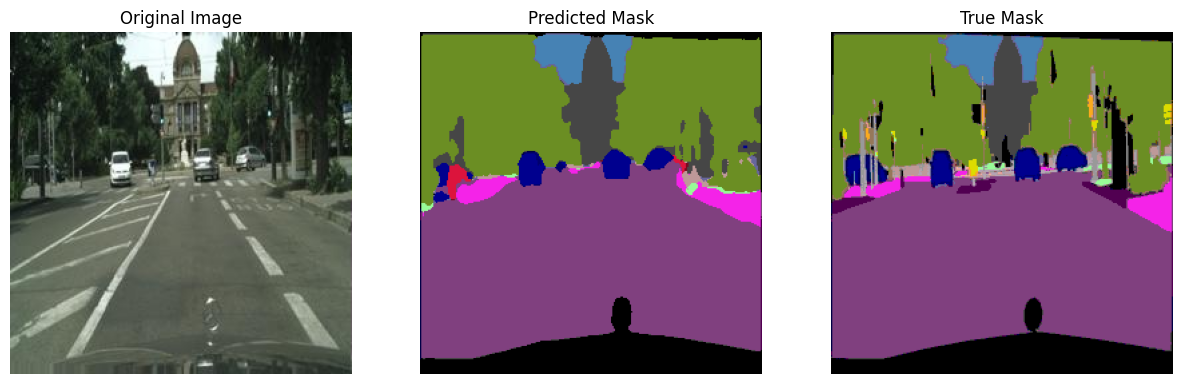

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.60it/s]



Epoch [18/100]
Training Loss: 0.6397, Training mIoU: 0.2324
Validation Loss: 0.6831, Validation mIoU: 0.2298


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 12 17 18 19 20 22 23 24 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


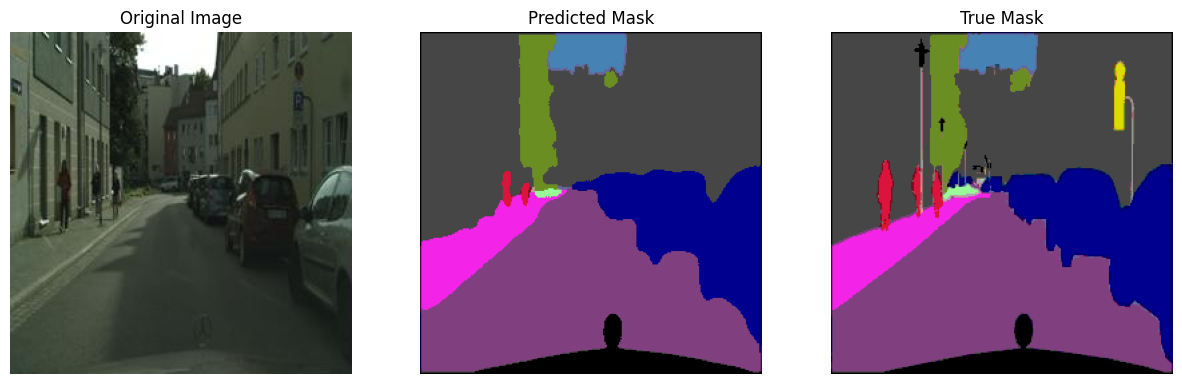

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.67it/s]



Epoch [19/100]
Training Loss: 0.6212, Training mIoU: 0.2361
Validation Loss: 0.6773, Validation mIoU: 0.2267


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


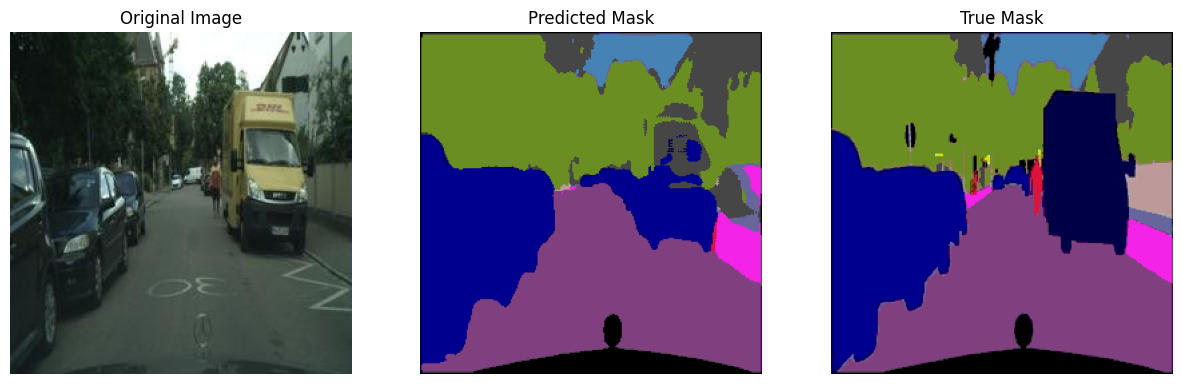

Validation: 100%|██████████| 43/43 [00:30<00:00,  1.40it/s]



Epoch [20/100]
Training Loss: 0.6089, Training mIoU: 0.2383
Validation Loss: 0.6847, Validation mIoU: 0.2302
EarlyStopping counter: 1 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 17 18 19 20 22 23 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


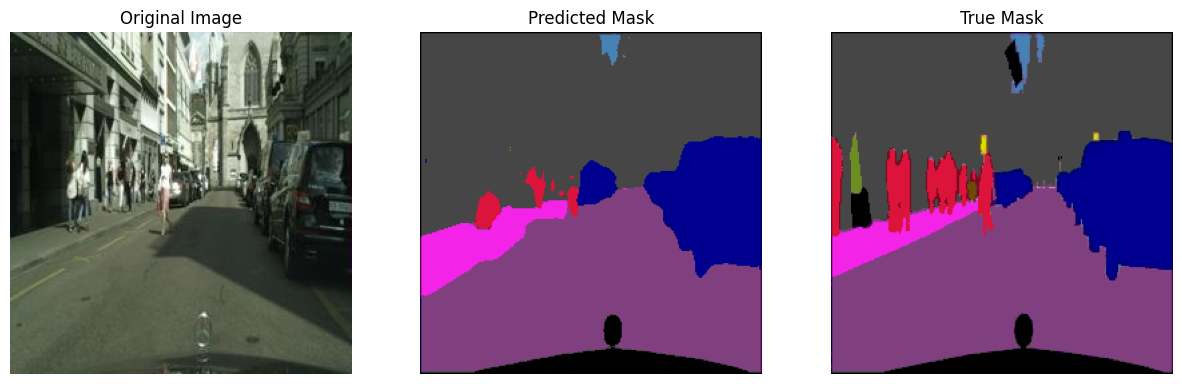

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s]



Epoch [21/100]
Training Loss: 0.5891, Training mIoU: 0.2452
Validation Loss: 0.6740, Validation mIoU: 0.2342
EarlyStopping counter: 2 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 12 17 18 19 20 22 23 24 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


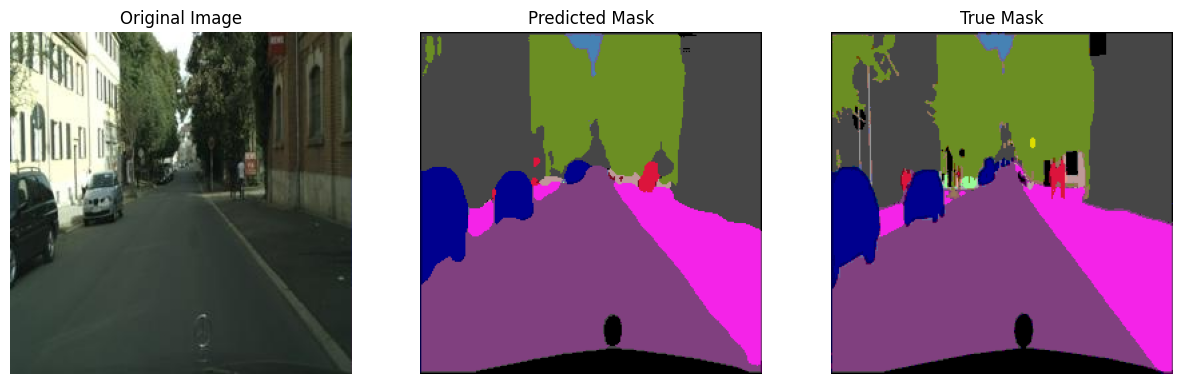

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.48it/s]



Epoch [22/100]
Training Loss: 0.5725, Training mIoU: 0.2495
Validation Loss: 0.6654, Validation mIoU: 0.2339


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


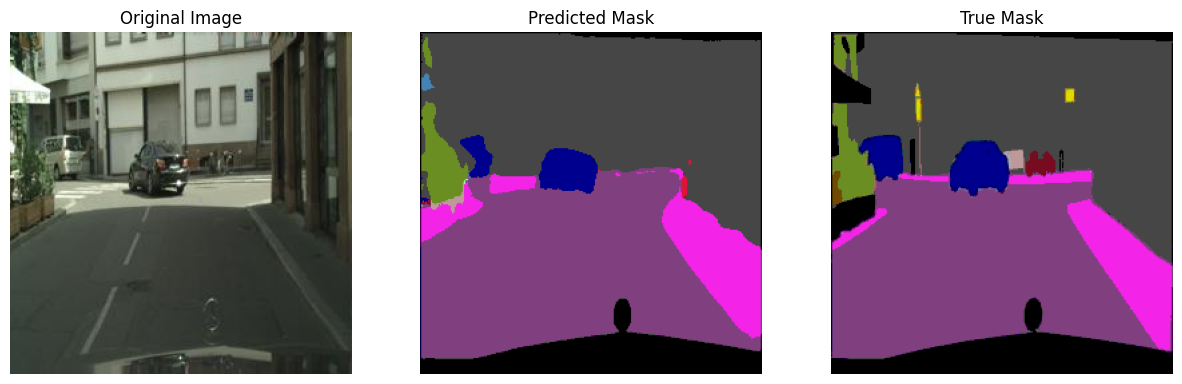

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.49it/s]



Epoch [23/100]
Training Loss: 0.5550, Training mIoU: 0.2540
Validation Loss: 0.6764, Validation mIoU: 0.2360
EarlyStopping counter: 1 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 17 18 19 20 22 23 24 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


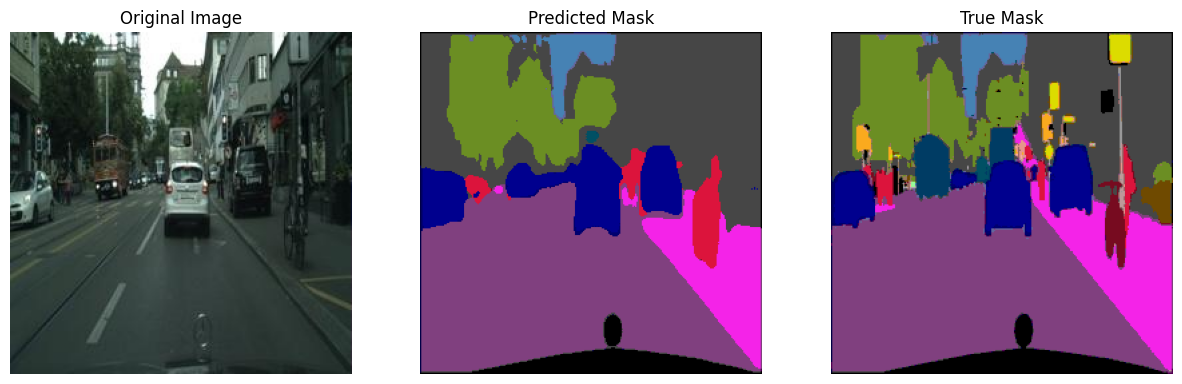

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.50it/s]



Epoch [24/100]
Training Loss: 0.5537, Training mIoU: 0.2572
Validation Loss: 0.6703, Validation mIoU: 0.2399
EarlyStopping counter: 2 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 17 18 19 20 22 23 24 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


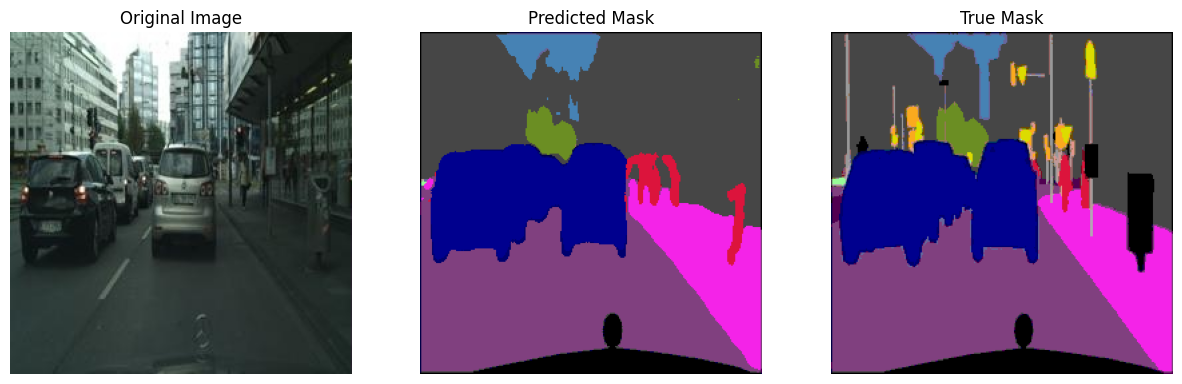

Validation: 100%|██████████| 43/43 [00:08<00:00,  5.35it/s]



Epoch [25/100]
Training Loss: 0.5311, Training mIoU: 0.2659
Validation Loss: 0.6770, Validation mIoU: 0.2447
EarlyStopping counter: 3 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 17 18 19 20 22 23 24 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


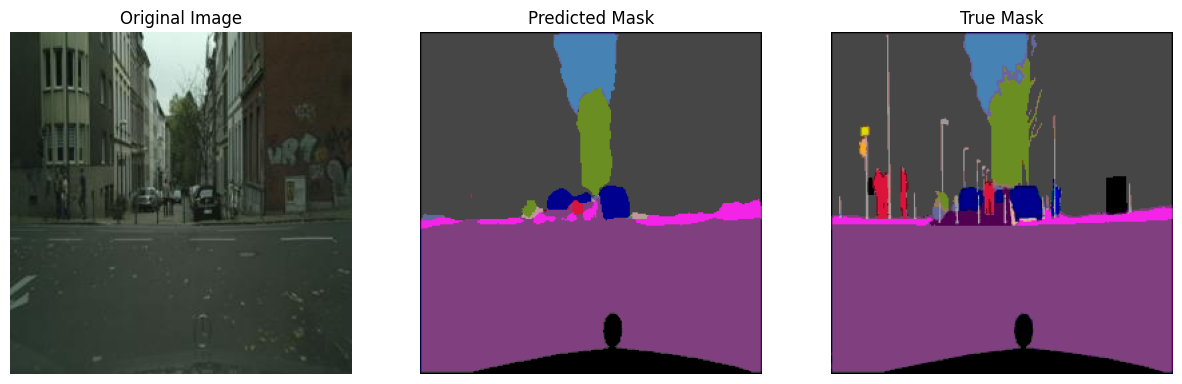

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.49it/s]



Epoch [26/100]
Training Loss: 0.5145, Training mIoU: 0.2741
Validation Loss: 0.6683, Validation mIoU: 0.2479
EarlyStopping counter: 4 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


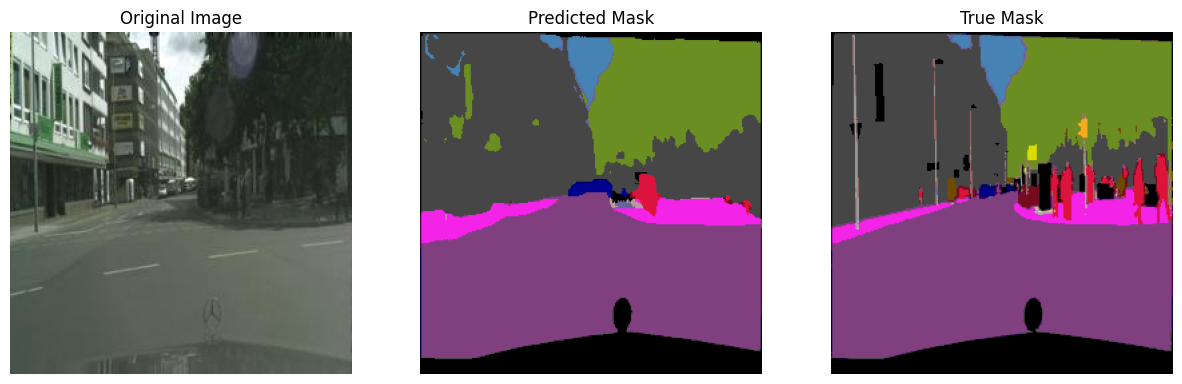

Validation: 100%|██████████| 43/43 [00:07<00:00,  5.49it/s]



Epoch [27/100]
Training Loss: 0.4879, Training mIoU: 0.2856
Validation Loss: 0.6741, Validation mIoU: 0.2501
EarlyStopping counter: 5 out of 10


  0%|          | 0/170 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 11 12 13 16 17 18 19 20 22 23 24 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


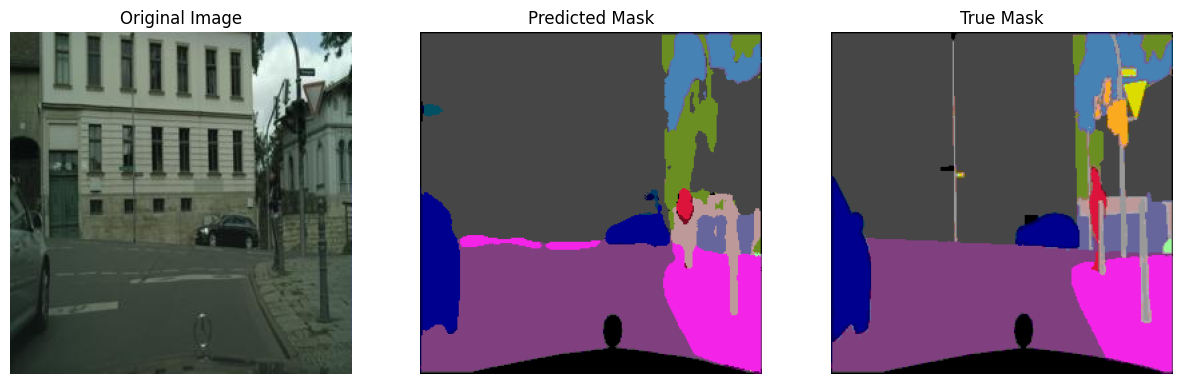

 55%|█████▌    | 94/170 [03:09<40:03, 31.63s/it]

In [ ]:
# Initialize model, loss function, and optimizer
model = UNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=10, min_delta=0.005, verbose=True, min_epochs=10)

# Add these lists before the training loop to store metrics
train_losses = []
val_losses = []
train_mious = []
val_mious = []

# Initialize the IoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_batch_mious = []
    batch_idx = 0
    # Use tqdm for progress bar
    for (images, masks) in tqdm(train_loader):
        # Move data to device
        images = images.float().to(device)
        # Remove the channel dimension (squeeze) from masks
        masks = masks.squeeze(1).long().to(device)  # Changed from squeeze(3) to squeeze(1)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Print loss every 10 batches
        #if (batch_idx + 1) % 10 == 0:
        #    print(f'Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}')
        
        # Print predictions for the first batch of each epoch
        
         # Calculate training mIoU
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            batch_miou = jaccard(preds, masks)
            train_batch_mious.append(batch_miou.item())

        if batch_idx == 0:
            with torch.no_grad():
                # Get predictions
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Convert tensors to numpy for visualization
                pred_masks = pred_masks.cpu().numpy()
                true_masks = masks.cpu().numpy()
                
                # Print shapes and unique values for debugging
                print(f"\nPredicted mask shape: {pred_masks.shape}")
                print(f"True mask shape: {true_masks.shape}")
                print(f"Unique values in prediction: {np.unique(pred_masks)}")
                print(f"Unique values in true mask: {np.unique(true_masks)}")
                
                # Convert predictions and true masks to RGB using id_map
                pred_rgb = np.zeros((pred_masks.shape[0], pred_masks.shape[1], pred_masks.shape[2], 3))
                true_rgb = np.zeros((true_masks.shape[0], true_masks.shape[1], true_masks.shape[2], 3))
                
                for i in range(pred_masks.shape[0]):
                    for key, value in id_map.items():
                        pred_rgb[i][pred_masks[i] == key] = value
                        true_rgb[i][true_masks[i] == key] = value
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(images[0].cpu().permute(1,2,0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(pred_rgb[0].astype(np.uint8))
                plt.title('Predicted Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(true_rgb[0].astype(np.uint8))
                plt.title('True Mask')
                plt.axis('off')
                
                plt.show()
        batch_idx = batch_idx + 1
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_mious = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validation'):
            images = images.float().to(device)
            masks = masks.squeeze(1).long().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate validation mIoU
            preds = torch.argmax(outputs, dim=1)
            batch_miou = jaccard(preds, masks)
            val_batch_mious.append(batch_miou.item())


    # Print average loss for the epoch
    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    epoch_train_miou = np.mean(train_batch_mious)
    epoch_val_miou = np.mean(val_batch_mious)

    # Store metrics
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_mious.append(epoch_train_miou)
    val_mious.append(epoch_val_miou)

     # Print metrics
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training mIoU: {epoch_train_miou:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation mIoU: {epoch_val_miou:.4f}')

    # Early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        model.load_state_dict(early_stopping.best_model)
        break

print('Training finished!')

# Plotting

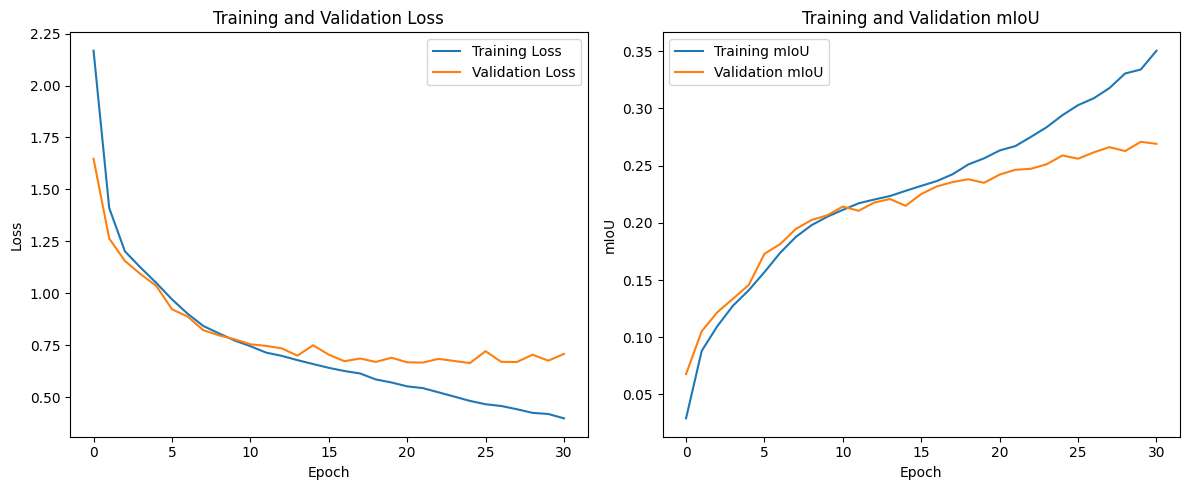

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# mIoU curve
plt.subplot(1, 2, 2)
plt.plot(train_mious, label='Training mIoU')
plt.plot(val_mious, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def save_model_as_npy(model, filepath):
    model_weights = model.state_dict()
    model_weights_dict = {k: v.cpu().numpy() for k, v in model_weights.items()}
    np.save(filepath, model_weights_dict)

In [ ]:
save_model_as_npy(model, 'best_Unet_weight.npy')

# Testing

Load weights successfully.


Testing:   0%|          | 0/36 [00:00<?, ?it/s]


Predicted mask shape: (14, 256, 256)
True mask shape: (14, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 15 16 17 18 19 20 22 23 24 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


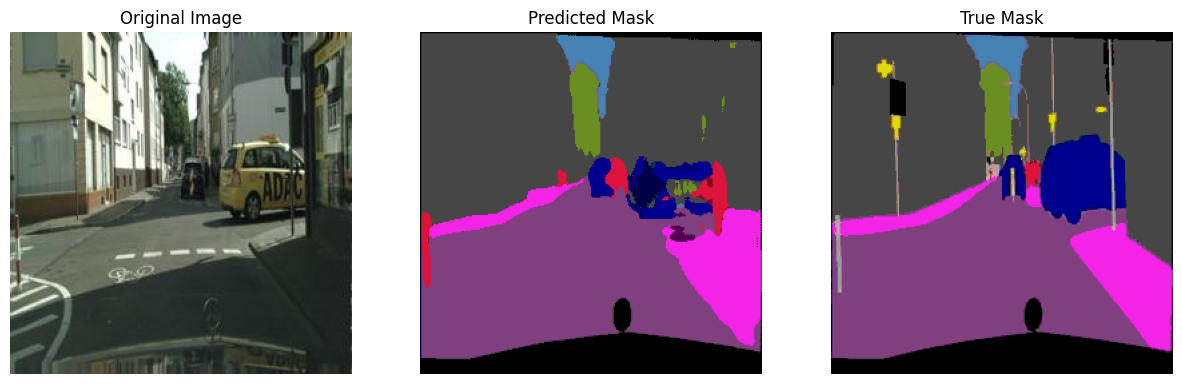

Testing: 100%|██████████| 36/36 [00:07<00:00,  4.52it/s]


Mean IoU: 0.2204
Mean Pixel Accuracy: 0.8113


Per-class IoU:   0%|          | 0/36 [00:00<?, ?it/s]


Mean IoU (excluding zeros): 0.4526
Mean IoU (including zeros): 0.1983
Mean Pixel Accuracy: 0.8113

IoU per class:
Class 0: 0.8920
Class 1: 0.0000
Class 2: 0.0674
Class 3: 0.8755
Class 4: 0.4943
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.5914
Class 8: 0.1395
Class 9: 0.0403
Class 10: 0.0003
Class 11: 0.0000
Class 12: 0.0002
Class 13: 0.0000
Class 14: 0.0000
Class 15: 0.0000
Class 16: 0.0053
Class 17: 0.7470
Class 18: 0.0602
Class 19: 0.8953
Class 20: 0.1939
Class 21: 0.0000
Class 22: 0.4863
Class 23: 0.3169
Class 24: 0.0035
Class 25: 0.0000
Class 26: 0.1238
Class 27: 0.0071
Class 28: 0.0000
Class 29: 0.0100

Number of classes with non-zero IoU: 13
Number of classes with zero IoU: 17


In [14]:
# Evaluate model (dummy example, replace with actual evaluation loop)
model = UNet(num_classes=num_classes).to(device)
weights = np.load('best_UNet_weight.npy', allow_pickle=True).item()

# Convert numpy arrays to torch tensors
state_dict = {k: torch.from_numpy(v) for k, v in weights.items()}
model.load_state_dict(state_dict)
print("Load weights successfully.")
model.eval()

image_dir = "cityscapes_data/cityscapes_data/val"
mask_dir = "cityscapes_data/cityscapes_data/val_mask"

dataset = CityscapeDataset(
        image_dir=image_dir,
        mask_dir=mask_dir
    )
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False
)

# Initialize the metric
jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

# Testing loop
model.eval()
miou_scores = []
pixel_accuracies = []


batch_idx = 0
with torch.no_grad():
    for images, masks in tqdm(dataloader, desc='Testing'):
        # Move data to device
        images = images.float().to(device)
        masks = masks.squeeze(1).long().to(device)  # Remove channel dimension
        
        # Forward pass
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate IoU
        batch_iou = jaccard(preds, masks)
        miou_scores.append(batch_iou.item())

         # Calculate pixel-wise accuracy
        correct_pixels = (preds == masks).sum().item()
        total_pixels = masks.numel()
        pixel_accuracy = correct_pixels / total_pixels
        pixel_accuracies.append(pixel_accuracy)

        # Print predictions for the first batch of each epoch
        if batch_idx == 0:
            with torch.no_grad():
                # Get predictions
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Convert tensors to numpy for visualization
                pred_masks = pred_masks.cpu().numpy()
                true_masks = masks.cpu().numpy()
                
                # Print shapes and unique values for debugging
                print(f"\nPredicted mask shape: {pred_masks.shape}")
                print(f"True mask shape: {true_masks.shape}")
                print(f"Unique values in prediction: {np.unique(pred_masks)}")
                print(f"Unique values in true mask: {np.unique(true_masks)}")
                
                # Convert predictions and true masks to RGB using id_map
                pred_rgb = np.zeros((pred_masks.shape[0], pred_masks.shape[1], pred_masks.shape[2], 3))
                true_rgb = np.zeros((true_masks.shape[0], true_masks.shape[1], true_masks.shape[2], 3))
                
                for i in range(pred_masks.shape[0]):
                    for key, value in id_map.items():
                        pred_rgb[i][pred_masks[i] == key] = value
                        true_rgb[i][true_masks[i] == key] = value
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(images[0].cpu().permute(1,2,0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(pred_rgb[0].astype(np.uint8))
                plt.title('Predicted Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(true_rgb[0].astype(np.uint8))
                plt.title('True Mask')
                plt.axis('off')
                
                plt.show()
        batch_idx = batch_idx + 1

# Calculate and print mean IoU and pixel-wise accuracy
mean_iou = np.mean(miou_scores)
mean_pixel_accuracy = np.mean(pixel_accuracies)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

# Calculate per-class IoU
class_iou = JaccardIndex(task="multiclass", num_classes=num_classes, average=None).to(device)
with torch.no_grad():
    for images, masks in tqdm(dataloader, desc='Per-class IoU'):
        images = images.float().to(device)
        masks = masks.squeeze(1).long().to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        iou_per_class = class_iou(preds, masks)
        break  # Just for one batch as example

# Move tensor to CPU and convert to numpy for calculations
iou_per_class = iou_per_class.cpu().numpy()

# Calculate mean IoU excluding zeros
non_zero_ious = [iou for iou in iou_per_class if iou > 0.05]
mean_iou_no_zeros = np.mean(non_zero_ious) if non_zero_ious else 0
mean_pixel_accuracy = np.mean(pixel_accuracies)

print(f"\nMean IoU (excluding zeros): {mean_iou_no_zeros:.4f}")
print(f"Mean IoU (including zeros): {np.mean(iou_per_class):.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

print("\nIoU per class:")
for class_id, iou in enumerate(iou_per_class):
    print(f"Class {class_id}: {iou:.4f}")

print(f"\nNumber of classes with non-zero IoU: {len(non_zero_ious)}")
print(f"Number of classes with zero IoU: {len(iou_per_class) - len(non_zero_ious)}")

# FLOPS

In [7]:
from calflops import calculate_flops

# Define a dummy input tensor with the same shape as your input images
dummy_input = (1, 3, 256, 256)  # Adjust the size if your input size is different

# Initialize your model
model = UNet(num_classes=num_classes).to(device)

flops, macs, params = calculate_flops(model=model, 
                                      input_shape=dummy_input,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  31.03 M 
fwd MACs:                                                               48.289 GMACs
fwd FLOPs:                                                              96.6602 GFLOPS
fwd+bwd MACs:                                                           144.867 GMACs
fwd+bwd FLOPs:                                                          289.981 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod

In [8]:
# Import required libraries
from torchviz import make_dot
from torch.autograd import Variable

def visualize_model_architecture(model):
    # Create sample input matching RefineNet's expected input shape (B, C, H, W)
    x = Variable(torch.randn(1, 3, 256, 256)).to(device)
    
    # Get model output
    y = model(x)
    
    # Create dot graph
    dot = make_dot(y, params=dict(model.named_parameters()))
    
    # Customize graph appearance
    dot.attr(rankdir='TB')  # Top to bottom layout
    dot.attr('node', shape='box')
    
    # Save visualization
    dot.render('refinenet_architecture', format='png', cleanup=True)
    
    print("Model architecture visualization has been saved as 'refinenet_architecture.png'")

# Visualize model
model = UNet(num_classes=num_classes).to(device)
visualize_model_architecture(model)

Model architecture visualization has been saved as 'refinenet_architecture.png'


In [16]:
def count_parameters(model):
    """
    Count the total number of trainable parameters in the model
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Convert to millions for better readability
    total_params_m = total_params / 1e6
    
    print(f'\nTotal Trainable Parameters: {total_params:,}')
    print(f'Total Trainable Parameters (M): {total_params_m:.2f}M')
    
    # Optional: Print parameters by layer
    print('\nParameters by layer:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel():,}')

# Call the function
model = UNet(num_classes=num_classes).to(device)
count_parameters(model)


Total Trainable Parameters: 31,033,630
Total Trainable Parameters (M): 31.03M

Parameters by layer:
enc1.0.weight: 1,728
enc1.0.bias: 64
enc1.2.weight: 36,864
enc1.2.bias: 64
enc2.0.weight: 73,728
enc2.0.bias: 128
enc2.2.weight: 147,456
enc2.2.bias: 128
enc3.0.weight: 294,912
enc3.0.bias: 256
enc3.2.weight: 589,824
enc3.2.bias: 256
enc4.0.weight: 1,179,648
enc4.0.bias: 512
enc4.2.weight: 2,359,296
enc4.2.bias: 512
enc5.0.weight: 4,718,592
enc5.0.bias: 1,024
enc5.2.weight: 9,437,184
enc5.2.bias: 1,024
up4.0.weight: 2,097,152
up4.0.bias: 512
dec4.0.weight: 4,718,592
dec4.0.bias: 512
dec4.2.weight: 2,359,296
dec4.2.bias: 512
up3.0.weight: 524,288
up3.0.bias: 256
dec3.0.weight: 1,179,648
dec3.0.bias: 256
dec3.2.weight: 589,824
dec3.2.bias: 256
up2.0.weight: 131,072
up2.0.bias: 128
dec2.0.weight: 294,912
dec2.0.bias: 128
dec2.2.weight: 147,456
dec2.2.bias: 128
up1.0.weight: 32,768
up1.0.bias: 64
dec1.0.weight: 73,728
dec1.0.bias: 64
dec1.2.weight: 36,864
dec1.2.bias: 64
final_conv.weight: 